In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [59]:
fixed_band_indices = [3]
bandnames = ['u', 'g', 'r', 'i', 'z']
num_fixed_bands = len(fixed_band_indices)

# load stellar model grids
npzfile = np.load('./model_grids.npz')
stellarmodel_grid = npzfile['model_grid']
stellarmodel_grid = stellarmodel_grid[:, ::10, ::2, :] ## UNCOMMENT THAT
plotstrides = 1
gridsize1, gridsize2, numtypes = stellarmodel_grid.shape[1:4]

# logg and Teff grids
loggDA_vec=np.linspace(7., 9.5, gridsize1)
loggDB_vec=np.linspace(7., 9., gridsize1)
temp_vec = np.logspace(np.log10(3000.), np.log10(120000.), gridsize2)

# random linear grids for the GP prior. Will need to specify the logg and T grids! For the GP prior
dim1_grid = np.linspace(0, 1, stellarmodel_grid.shape[1])
dim2_grid = np.linspace(0, 1, stellarmodel_grid.shape[2])

# load data
npzfile = np.load('./WD_data_very_clean.npz')
obsmags = npzfile['obsmags']
nobj, num_bands = obsmags.shape
obsmags_covar_chol = npzfile['obsmags_covar_chol']
obsmags_covar_logdet = npzfile['obsmags_covar_logdet']
obsmags_covar = obsmags_covar_chol[:, :, :] * np.swapaxes(obsmags_covar_chol[:, :, :], 1, 2)

In [60]:
nobj, nobj // 100

(4512, 45)

In [61]:
stellarmodel_grid.shape

(5, 50, 250, 2)

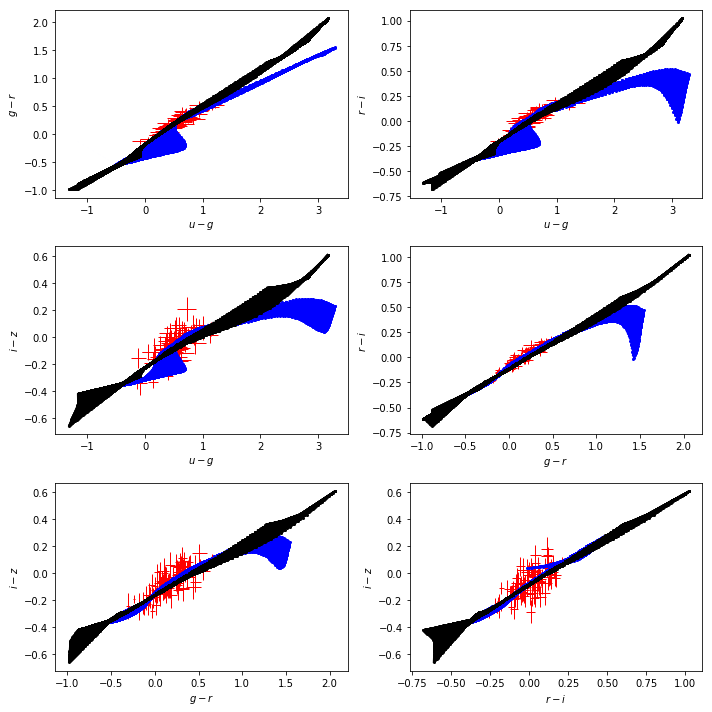

In [62]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.ravel()
off = -1
for i in range(num_bands-1):
    for j in range(i+1, num_bands-1):
        off += 1
        axs[off].set_xlabel('$'+bandnames[i]+'-'+bandnames[i+1]+'$')
        axs[off].set_ylabel('$'+bandnames[j]+'-'+bandnames[j+1]+'$')
        s = np.random.choice(nobj, 100, replace=False)
        axs[off].errorbar(obsmags[s, i] - obsmags[s, i+1], obsmags[s, j] - obsmags[s, j+1], 
                        xerr=np.sqrt(obsmags_covar[s, i, i] + obsmags_covar[s, i+1, i+1]), 
                        yerr=np.sqrt(obsmags_covar[s, j, j] + obsmags_covar[s, j+1, j+1]),
                          fmt = 'o', ms=0, lw=1, c='r'
                       )
        c = ['b', 'k']
        for t in range(0, 2):
            for g in range(0, stellarmodel_grid.shape[2], plotstrides):
                mod1 = stellarmodel_grid[i, ::plotstrides, g, t] - stellarmodel_grid[i+1, ::plotstrides, g, t]
                mod2 = stellarmodel_grid[j, ::plotstrides, g, t] - stellarmodel_grid[j+1, ::plotstrides, g, t]
                axs[off].errorbar(mod1.ravel(), mod2.ravel(), c=c[t], fmt='-o', ms=2)
                
fig.tight_layout()

In [63]:
corrected_stellarmodel_grid = np.load('corrected_model_grids.npy')
corrections_dim1 = np.load('corrections_dim1.npy')
corrections_dim2 = np.load('corrections_dim2.npy')



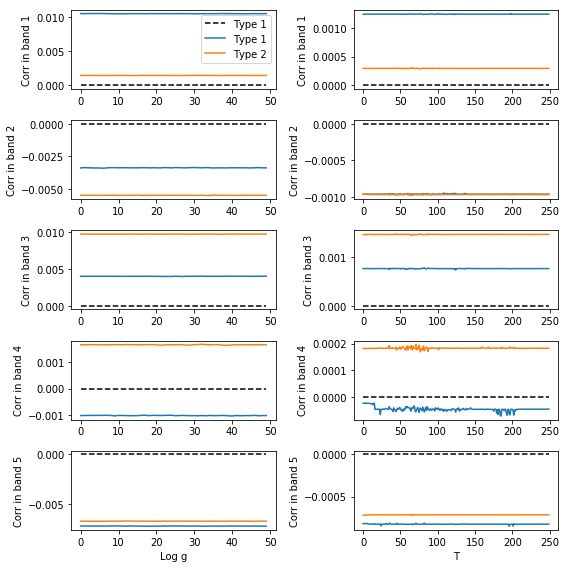

In [64]:
# num_bands, gridsize1, numtypes
fig, axs = plt.subplots(num_bands, 2, figsize=(8, 8), sharex=False)
for i in range(num_bands):
    axs[i, 0].plot(range(len(dim1_grid)), np.zeros(len(dim1_grid)), ls='--', c='k', label='Type 1')
    axs[i, 1].plot(range(len(dim2_grid)), np.zeros(len(dim2_grid)), ls='--', c='k', label='Type 2')
    axs[i, 0].plot(range(len(dim1_grid)), corrections_dim1[i, :, 0], label='Type 1')
    axs[i, 0].plot(range(len(dim1_grid)), corrections_dim1[i, :, 1], label='Type 2')
    axs[i, 1].plot(range(len(dim2_grid)), corrections_dim2[i, :, :])
    axs[i, 0].set_ylabel('Corr in band '+str(i+1))
    axs[i, 1].set_ylabel('Corr in band '+str(i+1))
axs[-1, 0].set_xlabel('Log g')
axs[-1, 1].set_xlabel('T')
axs[0, 0].legend()
fig.tight_layout()

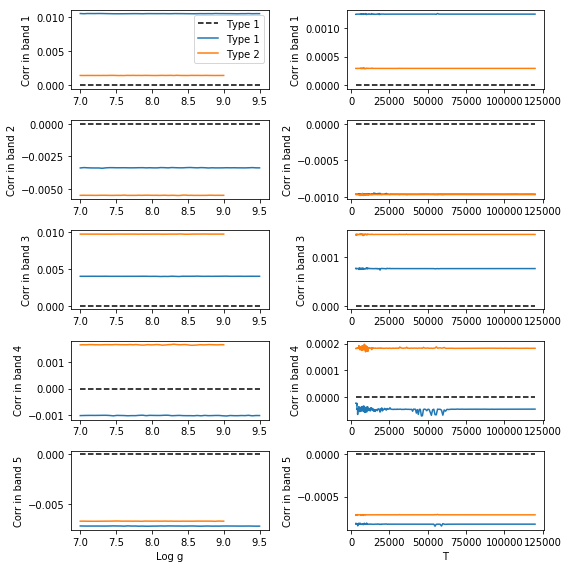

In [65]:
# TODO: add actual log g and T grids!
# num_bands, gridsize1, numtypes
fig, axs = plt.subplots(num_bands, 2, figsize=(8, 8), sharex=False)
for i in range(num_bands):
    axs[i, 0].plot(loggDA_vec, np.zeros(len(dim1_grid)), ls='--', c='k', label='Type 1')
    axs[i, 1].plot(temp_vec, np.zeros(len(dim2_grid)), ls='--', c='k', label='Type 2')
    axs[i, 0].plot(loggDA_vec, corrections_dim1[i, :, 0], label='Type 1')
    axs[i, 0].plot(loggDB_vec, corrections_dim1[i, :, 1], label='Type 2')
    axs[i, 1].plot(temp_vec, corrections_dim2[i, :, :])
    axs[i, 0].set_ylabel('Corr in band '+str(i+1))
    axs[i, 1].set_ylabel('Corr in band '+str(i+1))
axs[-1, 0].set_xlabel('Log g')
axs[-1, 1].set_xlabel('T')
axs[0, 0].legend()
fig.tight_layout()



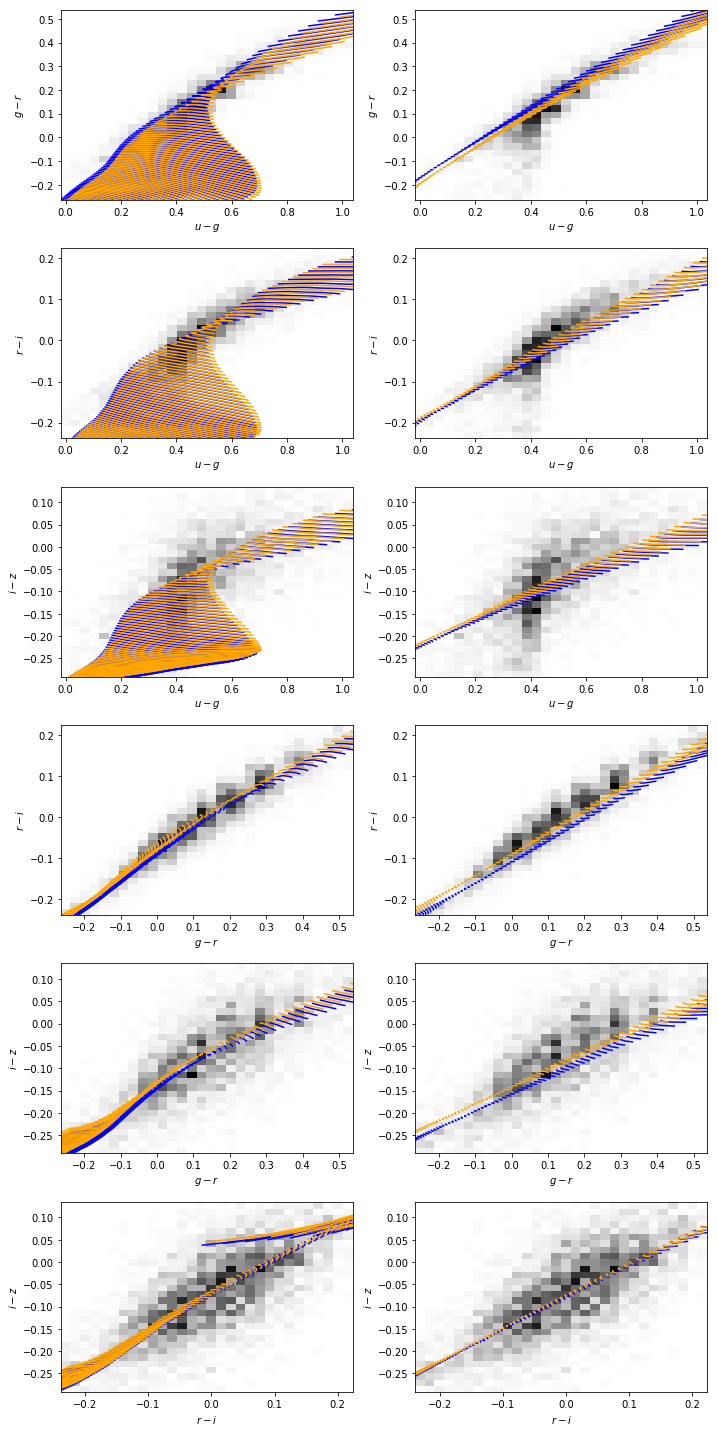

In [66]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
#axs = axs.ravel()
off = -1
def custom_range(x, factor=2):
    m = np.mean(x)
    s = np.std(x)
    return [m  - factor*s, m + factor * s]
for i in range(num_bands-1):
    for j in range(i+1, num_bands-1):
        off += 1
        norm = None;#LogNorm()#
        rr = [[-0.6, 1.5], [-0.6, 1]]
        for t in range(0, 2):
            rr = [custom_range(obsmags[:, i] - obsmags[:, i+1]), custom_range(obsmags[:, j] - obsmags[:, j+1])]
            axs[off, t].hist2d(obsmags[:, i] - obsmags[:, i+1], obsmags[:, j] - obsmags[:, j+1], 
                            30, norm=norm, range=rr, cmap='Greys', zorder=0)
            axs[off, t].set_xlabel('$'+bandnames[i]+'-'+bandnames[i+1]+'$')
            axs[off, t].set_ylabel('$'+bandnames[j]+'-'+bandnames[j+1]+'$')
            for g in range(0, stellarmodel_grid.shape[2], plotstrides):
                mod1 = stellarmodel_grid[i, ::plotstrides, g, t] - stellarmodel_grid[i+1, ::plotstrides, g, t]
                mod2 = stellarmodel_grid[j, ::plotstrides, g, t] - stellarmodel_grid[j+1, ::plotstrides, g, t]
                axs[off, t].plot(mod1.ravel(), mod2.ravel(), c='blue', zorder=1)
                mod1 = corrected_stellarmodel_grid[i, ::plotstrides, g, t] - corrected_stellarmodel_grid[i+1, ::plotstrides, g, t]
                mod2 = corrected_stellarmodel_grid[j, ::plotstrides, g, t] - corrected_stellarmodel_grid[j+1, ::plotstrides, g, t]
                axs[off, t].plot(mod1.ravel(), mod2.ravel(), c='orange', zorder=2)
                
fig.tight_layout()